## Setting up environment

In [103]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

In [104]:
# Set plotting settings
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
# Color palettes for organs
scimap = ["#A50CFA", "#FF804B", "#0000FF", "#009800", "#B90000", "#660000", 
          "#FF0000", "#61FFE2", "#00FF82", "#FF86FF", "#FFB623", "#FFFF00"]
azi = ["#A50CFA", "#FF804B", "#FF0000", "#FFFF00"]

## Loading data

In [105]:
data = pd.read_csv("https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/main/output-data/v0.9.0/reports/atlas/validation-v5.csv")
data.head()

,sex,consortium_name,dataset,tool,modality,reported_organ,organ,organId,rui_location_volume,cell_id,cell_label,cell_count,percentage
0,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002063,AT2,758,0.145294
1,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002062,AT1,745,0.142802
2,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,623,0.119417
3,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002144,EC general capillary,561,0.107533
4,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0000913,CD8 T cells,478,0.091624


## Cleaning up strings and setting categorical variables

First, we process the text data in the 'organ' variable to remove extraneous words.

In [106]:
data.organ = data.organ.str.replace("left ","", regex=True)
data.organ = data.organ.str.replace("right ","", regex=True)
data.organ = data.organ.str.replace("Set of ","", regex=True)
data.organ = data.organ.str.title()
data.organ = data.organ.str.replace("In","in", regex=True)

Next, we set variable data types.

In [107]:
data.organ = data.organ.astype("category")
data['organCode'] = data['organ'].cat.codes
data.organId = data.organId.astype("category")
data.reported_organ = data.reported_organ.astype("category")
data.consortium_name = data.consortium_name.astype("category")
data['consCode'] = data['consortium_name'].cat.codes
data.dataset = data.dataset.astype("category")
data.modality = data.modality.astype("category")
data.cell_id = data.cell_id.astype("category")
data.cell_label = data.cell_label.astype("category")

## Create Pivot tables using datasets and cell_ids.
The first pivot table collects the measured cell type counts for each dataset. The second pivot table collects the percentage of cell types for each dataset. Both use the minimum aggregation function, as is only one measurement per cell type per data set. Pivoting is done on the dataset id, anatomical structure (organ), and tool used in the cell type analysis.

### UMAP All Tools

In [110]:
data_cellperc = data.pivot_table(index=['dataset','organ','tool'],
                                        columns='cell_id',
                                        values='percentage',
                                        aggfunc='min',
                                        fill_value='0',
                                        observed=True,
                                        margins=False)
data_cellperc.shape

(945, 351)

Note, that when 'tool' is added to this pivot, the number of dataset records analyzed is 945 rows. When the 'tool' variable is removed from the pivot index, the number of dataset rows shrinks to 553, which indicates that many data sets were analyzed using multiple tools.

### UMAP Azimuth Subset

In [111]:
data_cellperc_a = data[data['tool'].isin({'azimuth'})]
data_cellperc_a = data_cellperc_a.pivot_table(index=['dataset','organ','tool'],
                                              columns='cell_id',
                                              values='percentage',
                                              aggfunc='min',
                                              fill_value='0',
                                              observed=True,
                                              margins=False)
data_cellperc_a.shape

(365, 93)

Note that the number of cell type (93 columns) identified in by the *azimuth* tool is smaller than the number of cell types identified by *popv* and *celltypist* tools (233 columns).

#### UMAP PopV

In [112]:
data_cellperc_p = data[data['tool'].isin({'popv'})]
data_cellperc_p = data_cellperc_p.pivot_table(index=['dataset','organ','tool'],
                                              columns='cell_id',
                                              values='percentage',
                                              aggfunc='min',
                                              fill_value='0',
                                              observed=True,
                                              margins=False)
data_cellperc_c.shape

(237, 233)

#### UMAP Cell Typist

In [113]:
data_cellperc_c = data[data['tool'].isin({'celltypist'})]
data_cellperc_c = data_cellperc_c.pivot_table(index=['dataset','organ','tool'],
                                              columns='cell_id',
                                              values='percentage',
                                              aggfunc='min',
                                              fill_value='0',
                                              observed=True,
                                              margins=False)
data_cellperc_c.shape

(237, 233)

In [114]:
data_organs = data[['dataset','organ','organCode']].drop_duplicates()
data_consortium = data[['dataset','consortium_name','consCode']].drop_duplicates() 

## UMAP Analysis

### Scaling UMAP data sets

In [115]:
scaled_data_celltype = StandardScaler().fit_transform(data_celltype)
scaled_data_celltype_a = StandardScaler().fit_transform(data_cellperc_a)
scaled_data_celltype_p = StandardScaler().fit_transform(data_cellperc_c)
scaled_data_celltype_c = StandardScaler().fit_transform(data_cellperc_p)

titlestring = "UMAP HRA-Pop Data Sets Cell Type Percentages"

### UMAP Settings 
The UMAP reducers for all of the UMAPS will use the same hyperparameters setting: 
* Metric = *Euclidean Distance*
* Neighbors = 50
* Minimum distance is set to .1

#### UMAP - All Cell Types and Tools

In [116]:
reducer = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(scaled_data_celltype)

Text(0.0, 1.0, 'Distance Metric: Euclidean Distance')

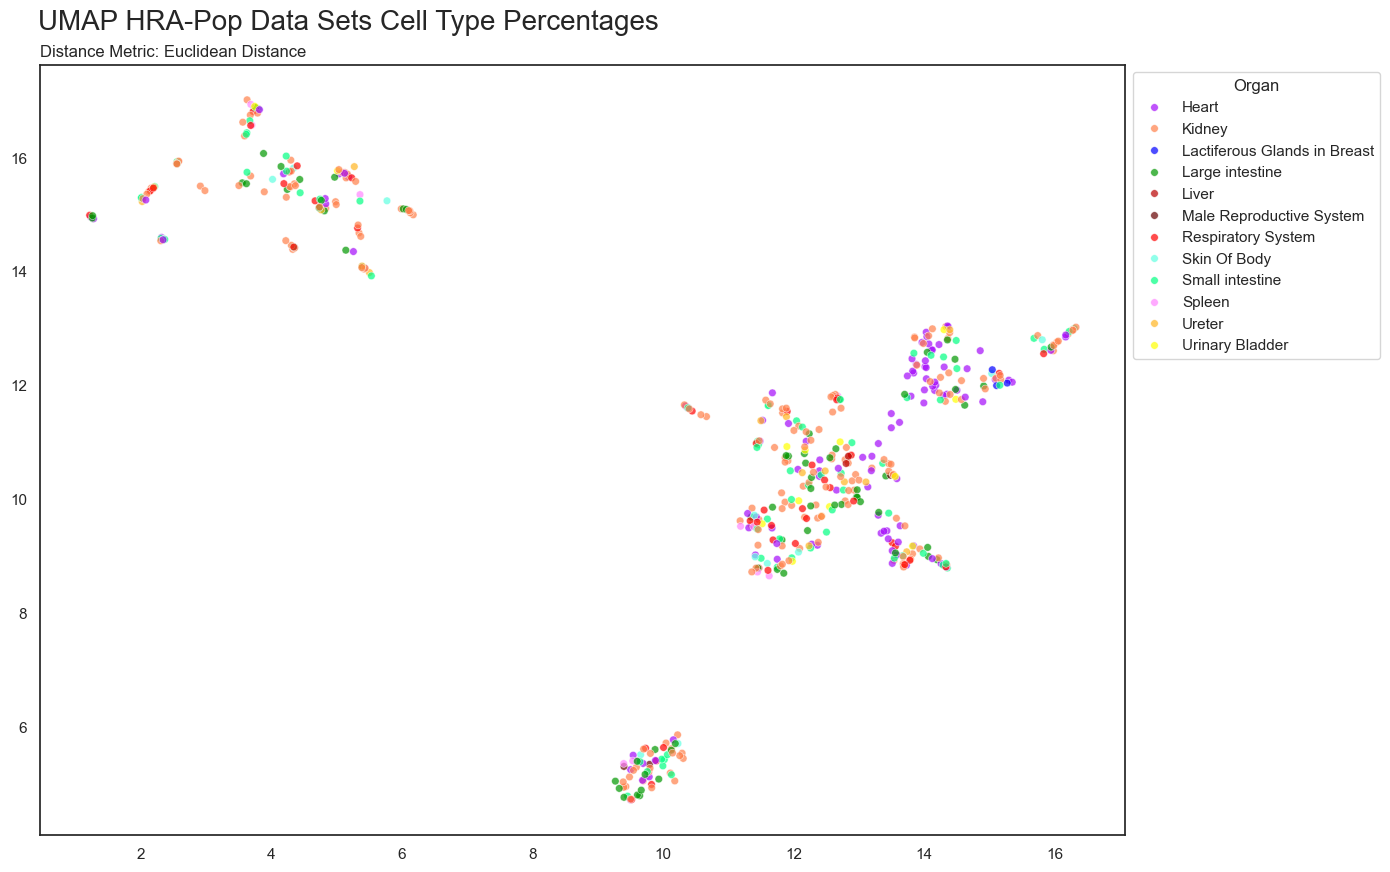

In [117]:
sns.set_palette(scimap)
sns.scatterplot(x = embedding[:, 0], 
                y = embedding[:, 1], s=30,
                hue=data_organs.organ, alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.suptitle(titlestring, x=0.345, y=.935, fontsize=20)
plt.title('Distance Metric: Euclidean Distance', loc='left', fontsize=12)

#### UMAP Azimuth Tools
This UMAP analysis processes all data sets that used the Azimuth tool for cell type identification.

In [119]:
reducer2 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_a = reducer2.fit_transform(scaled_data_celltype_a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1.0, 'Azimuth')

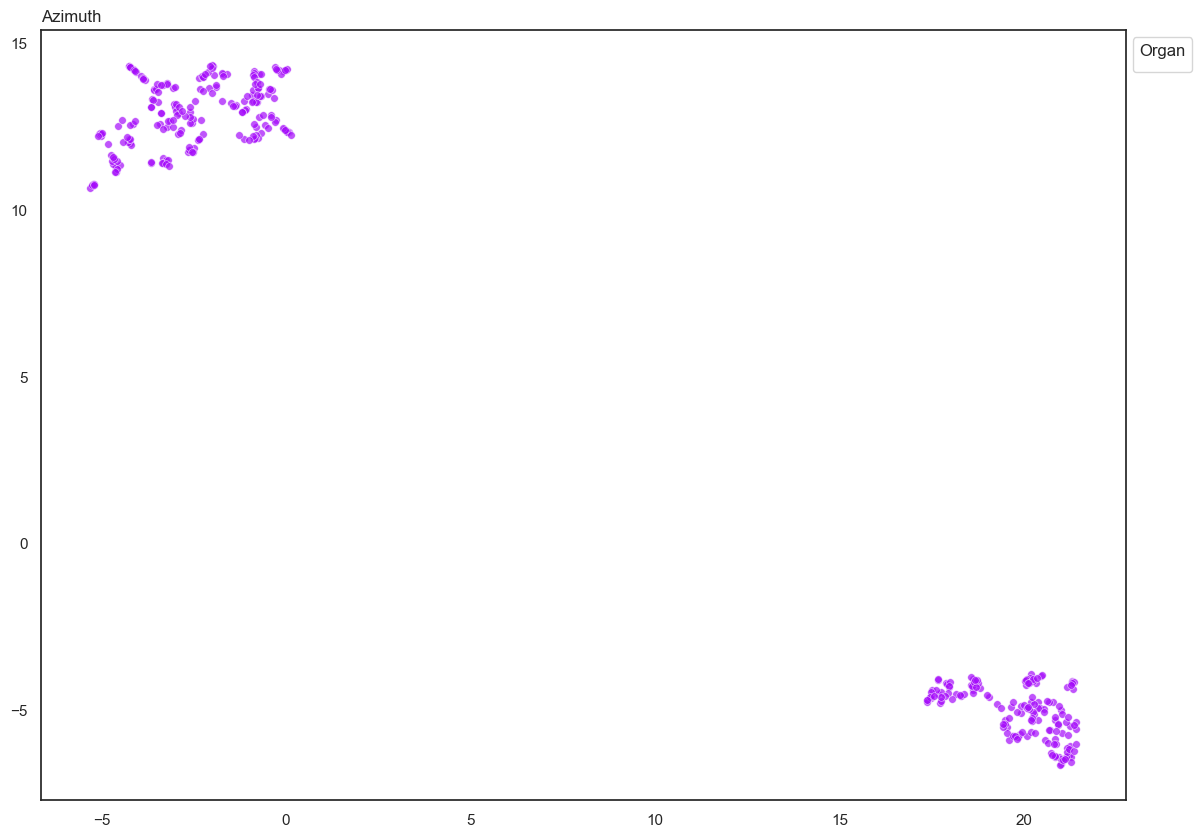

In [134]:
sns.scatterplot(x = embedding_a[:, 0], 
                y = embedding_a[:, 1], s=30,
               alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Azimuth', loc='left', fontsize=12)

#### UMAP Cell Typist

In [130]:
reducer3 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_c = reducer3.fit_transform(scaled_data_celltype_c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1.0, 'Cell Typist')

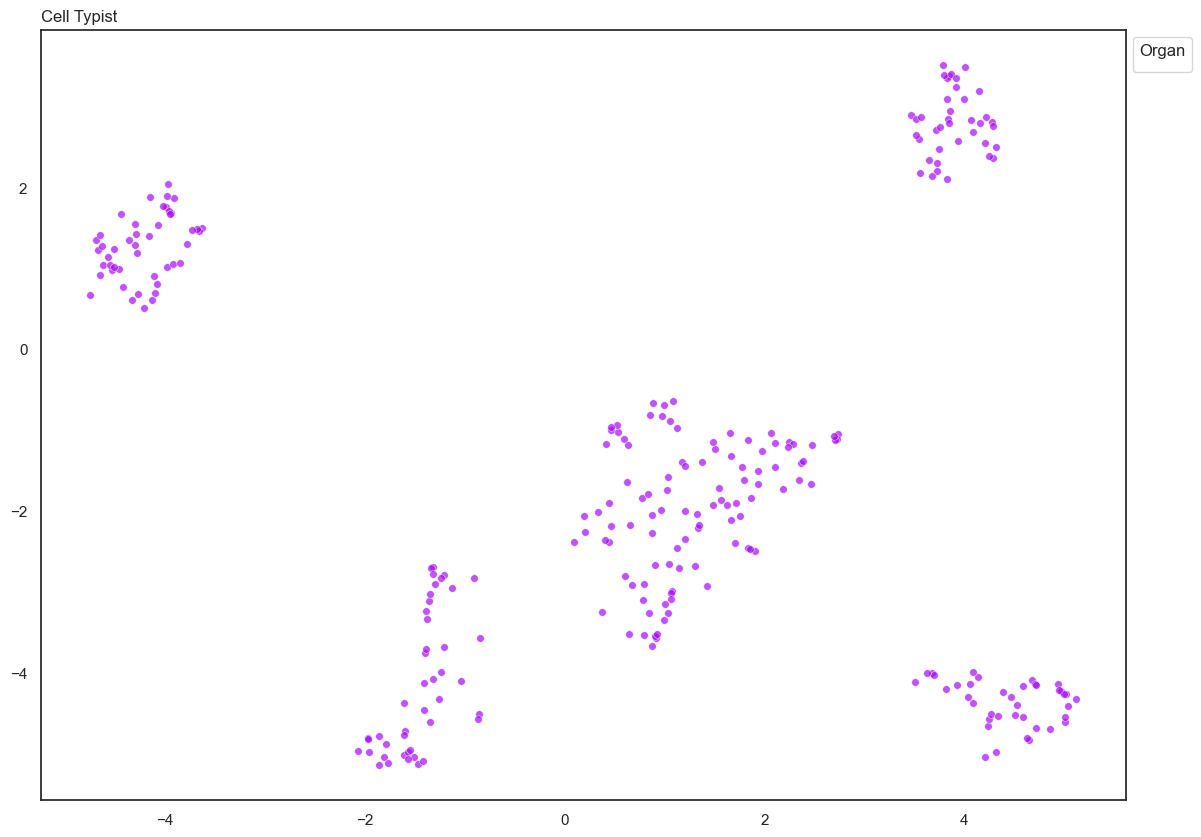

In [135]:
sns.scatterplot(x = embedding_c[:, 0], 
                y = embedding_c[:, 1], s=30,
               alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Cell Typist', loc='left', fontsize=12)

#### UMAP Pop V

In [132]:
reducer4 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_p = reducer4.fit_transform(scaled_data_celltype_p)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1.0, 'Pop V Tool')

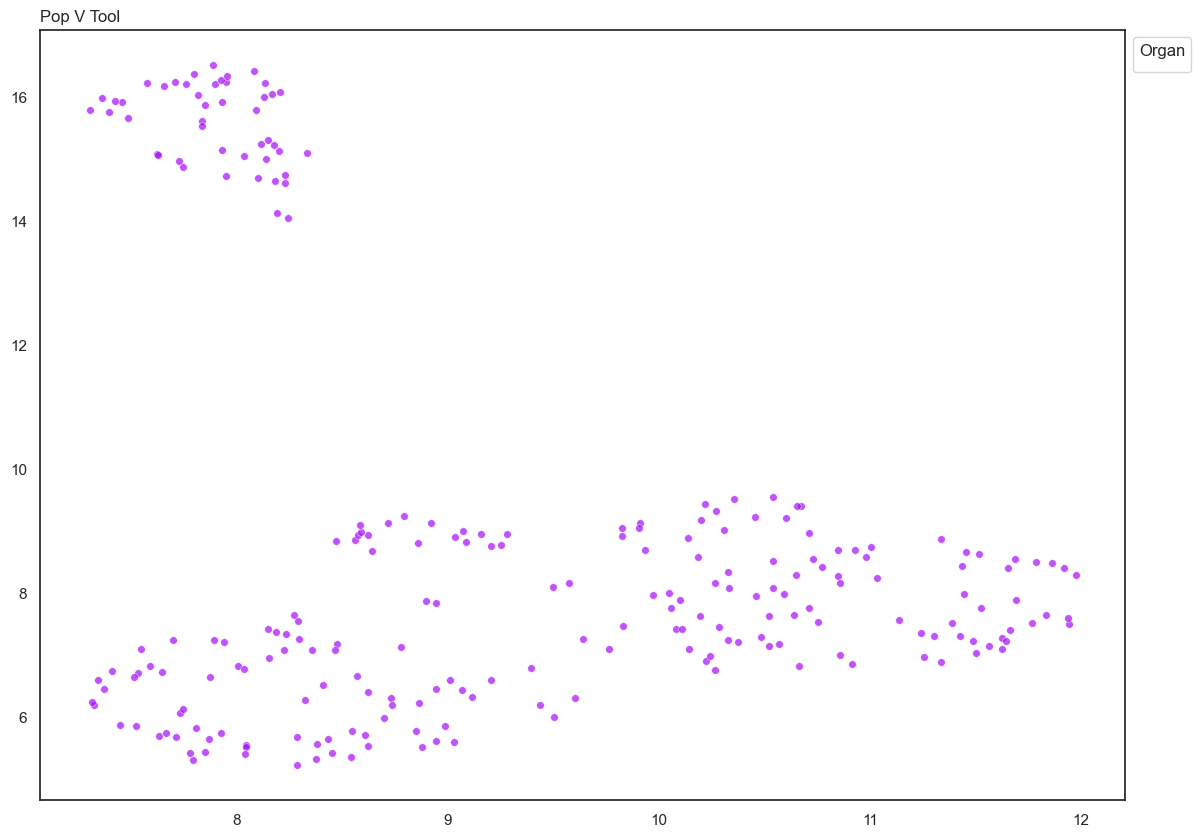

In [136]:
sns.scatterplot(x = embedding_p[:, 0], 
                y = embedding_p[:, 1], s=30,
               alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Pop V Tool', loc='left', fontsize=12)